In [70]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel, LongformerTokenizer, LongformerModel, AutoModelForSeq2SeqLM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import optuna
from tqdm import tqdm

import matplotlib.pyplot as plt
import textwrap
import datetime as dt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# function to calculate our financial metrics and then scale numerical columns for LSTM
def preprocess_data(df):
    
    # calculate on balance volume
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # calculate exponential moving average
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

    # calculate 20-day simple moving average
    df['SMA_20'] = df['Close'].rolling(window=20).mean()

    # calculate standard deviation
    df['STD_20'] = df['Close'].rolling(window=20).std()

    # calculate the upper and lower bollinger bands
    df['Upper_BB'] = df['SMA_20'] + (df['STD_20'] * 2)
    df['Lower_BB'] = df['SMA_20'] - (df['STD_20'] * 2)
    
    # remove null values
    df = df.dropna().reset_index()
     
    # scale the numerical 
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
        
    
    return df, scaler

In [5]:
torch.cuda.empty_cache()

# load  dataset
df = pd.read_csv("data/yahoo_news/data.csv")

# convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# sort by date
df = df.sort_values(by='Date')

# split our dataset before preprocessing to avoid look ahead bias
split1 = int(len(df) * 0.6)
split2 = int(len(df) * 0.8)

train_df = df.iloc[:split1].reset_index()
dev_df = df.iloc[split1:split2].reset_index()
test_df = df.iloc[split2:].reset_index()

# define numerical columns
numerical_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'OBV', 'EMA_20', 'Upper_BB', 'Lower_BB']

# tokenize data and add technical indicators
train_df, _ = preprocess_data(train_df)
dev_df, _ = preprocess_data(dev_df)
test_df, scaler = preprocess_data(test_df)

In [80]:
# calculate the number of tokens we need to process to cover 90% of our text
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

token_lengths = df['content'].apply(lambda x: len(tokenizer.tokenize(x)))

print(token_lengths.describe())
print(token_lengths.quantile(.9))

In [6]:
# function to summarize long article content
def summarize(data, batch_size, max_input_length, summary_length, model_name = "google-t5/t5-small"):
    
    torch.cuda.empty_cache()
    
    # add summarization prefix to text for generation
    prefix = "summarize: "
    text = [prefix + doc for doc in df["content"]]
    
    # intialize model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    
    # transfer model to GPU
    model.to(device)
    
    summaries = []
        
    # process batches with progress bar
    for i in tqdm(range(0, len(text), batch_size)):

        # select current batch
        batch_texts = text[i:i+batch_size]

        # tokenize batch
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length).input_ids

        # get outputs
        with torch.no_grad():
            outputs = model.generate(inputs.to(device), max_new_tokens=summary_length)

        # decode our summary tokens into text
        batch_summaries = [tokenizer.decode(tokens, skip_special_tokens=True) for tokens in outputs]

        # append batch summaries to list
        summaries += batch_summaries
    
    return summaries
    
    

In [7]:
# function to calculate embeddings for news content and headlines in our dataset.  
def get_embeddings(data, batch_size = 32, max_length=512, embedding_method="headline", model_name="ProsusAI/finbert"):
    
    torch.cuda.empty_cache()
    
    # decide what content we'll be embedding
    # for headline, we only embed the title of the article
    if embedding_method == "headline":
        text = df['title'].tolist()
        
    # for summary, we generate a summary of the content of our article
    elif embedding_method == "summary":
        # we choose to use a maximum content length for our summary of 1500 tokens because
        # that should fully cover 90% of our news articles
        text = summarize(df['content'], batch_size=64, max_input_length=1500, summary_length=max_length, model_name="google-t5/t5-small")

    else:
        # for truncation and longformer we start with the full content
        text = df['content'].tolist()
    
    # use different settings for longformers
    if embedding_method == "longformer": # must be used with "allenai/longformer-base-4096"
        
        # initialize model and tokenizer
        model = LongformerModel.from_pretrained(model_name)
        tokenizer = LongformerTokenizer.from_pretrained(model_name)
        
    else:     
        # initialize model and tokenizer
        model = AutoModel.from_pretrained(model_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # transfer modelto GPU
    model.to(device)
        
    embeddings = []
        
    # process batches with progress bar
    for i in tqdm(range(0, len(text), batch_size)):

        # select current batch
        batch_texts = text[i:i+batch_size]

        # tokenize  batch
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # get outputs
        with torch.no_grad():
            outputs = model(**inputs)

        # get embedding of CLS token
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

        # append batch embeddings to list
        embeddings.append(batch_embeddings)
    
    # combine our batches into a single array
    return np.concatenate(embeddings)

In [8]:
# define dataset class
class StockPredictionDataset(Dataset):
    def __init__(self, df, embeddings, seq_length):
        # initialize variables
        self.df = df
        self.embeddings = embeddings
        self.seq_length = seq_length

    def __len__(self):
        return len(self.df) - self.seq_length

    def __getitem__(self, idx):
        # slice for batch processing
        embedding = self.embeddings[idx:idx+self.seq_length]
        seq = self.df.iloc[idx:idx+self.seq_length]
        label = self.df.iloc[idx+self.seq_length]['Close']
        
        # return tensors
        return (torch.tensor(embedding),
                torch.tensor(seq[numerical_cols].values, dtype=torch.float32),
                torch.tensor(label, dtype=torch.float32))

In [9]:
method = "headline" # choose from headline, truncated, summary, and longformer

# we use 5 day sequences to predict the next day
sequence_length = 5
batch_size = 32

if method == "longformer":
    batch_size = 64
    max_length = 1500
    model_name = "allenai/longformer-base-4096"
else:
    batch_size = 500
    max_length = 512
    model_name = "sentence-transformers/all-MiniLM-L6-v2"

# generate embeddings for text features
train_embeddings = get_embeddings(train_df, batch_size = batch_size, max_length = max_length, embedding_method = method, model_name=model_name)
dev_embeddings = get_embeddings(dev_df, batch_size = batch_size, max_length = max_length, embedding_method = method, model_name=model_name)
test_embeddings = get_embeddings(test_df, batch_size = batch_size, max_length = max_length, embedding_method = method, model_name=model_name)

# create training and test datasets
train_dataset = StockPredictionDataset(train_df, train_embeddings, sequence_length)
dev_dataset = StockPredictionDataset(dev_df, dev_embeddings, sequence_length)
test_dataset = StockPredictionDataset(test_df, test_embeddings, sequence_length)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 32/32 [00:01<00:00, 20.96it/s]


In [10]:
# define LSTM model
class LSTM(nn.Module):
    def __init__(self, embedding_dim, num_features, hidden_dim, num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(embedding_dim + num_features, hidden_dim, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, text_embeddings, numerical_features):
        # concatenate embeddings and numerical features
        combined = torch.cat((text_embeddings, numerical_features), dim=2)
        lstm_out, _ = self.lstm(combined)
        # take output from last time step
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out

In [14]:
# define parameters
embedding_dim = len(train_embeddings[0])
num_features = len(numerical_cols)


# define objective function for optuna
def objective(trial):
    
    torch.cuda.empty_cache()
    
    # hyperparameters to tune
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_epochs = trial.suggest_int('num_epochs', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    
    model = LSTM(embedding_dim, num_features, hidden_dim, num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for text_embeddings, numerical_features, labels in train_loader:
            text_embeddings, numerical_features, labels = text_embeddings.to(device), numerical_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(text_embeddings, numerical_features)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Loss: {avg_train_loss}')
        
        # validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for text_embeddings, numerical_features, labels in dev_loader:
                text_embeddings, numerical_features, labels = text_embeddings.to(device), numerical_features.to(device), labels.to(device)
                outputs = model(text_embeddings, numerical_features)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()
                
        avg_val_loss = val_loss / len(dev_loader)
        print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss}')
    
    return avg_val_loss

# create optuna study and optimize
study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=15)
study.optimize(objective, n_trials=1)

# print best hyperparameters
print('Best hyperparameters: ', study.best_params)

# train final model with the best hyperparameters
best_params = study.best_params
model = LSTM(embedding_dim, num_features, best_params['hidden_dim'], best_params['num_layers']).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])


for epoch in range(best_params['num_epochs']):
    model.train()
    train_loss = 0.0
    for text_embeddings, numerical_features, labels in train_loader:
        text_embeddings, numerical_features, labels = text_embeddings.to(device), numerical_features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(text_embeddings, numerical_features)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}')

    # validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for text_embeddings, numerical_features, labels in dev_loader:
            text_embeddings, numerical_features, labels = text_embeddings.to(device), numerical_features.to(device), labels.to(device)
            outputs = model(text_embeddings, numerical_features)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()

    print(f'Epoch {epoch+1}, Validation Loss: {val_loss/len(dev_loader)}')

[I 2024-07-20 15:46:53,700] A new study created in memory with name: no-name-a484dc60-8b41-4dbf-997c-c7276ed64587


Epoch 1, Loss: 1.0014100087806583
Epoch 1, Validation Loss: 0.954968124628067
Epoch 2, Loss: 0.7518273068591952
Epoch 2, Validation Loss: 0.4220356877361025
Epoch 3, Loss: 0.5419545236974954
Epoch 3, Validation Loss: 0.4927074611186981
Epoch 4, Loss: 0.16820444203913212
Epoch 4, Validation Loss: 0.25764306634664536
Epoch 5, Loss: 0.13472907543182372
Epoch 5, Validation Loss: 0.23679048142262868
Epoch 6, Loss: 0.0650736190378666
Epoch 6, Validation Loss: 0.2845006744776453
Epoch 7, Loss: 0.10670454818755389


[I 2024-07-20 15:47:43,437] Trial 0 finished with value: 0.19289918669632503 and parameters: {'hidden_dim': 83, 'num_layers': 2, 'num_epochs': 7, 'learning_rate': 0.001961841216970556}. Best is trial 0 with value: 0.19289918669632503.


Epoch 7, Validation Loss: 0.19289918669632503
Best hyperparameters:  {'hidden_dim': 83, 'num_layers': 2, 'num_epochs': 7, 'learning_rate': 0.001961841216970556}
Epoch 1, Loss: 0.8951044952496886
Epoch 1, Validation Loss: 0.8017951590674264
Epoch 2, Loss: 0.5289347797632218
Epoch 2, Validation Loss: 0.333173115338598
Epoch 3, Loss: 0.25478767063468694
Epoch 3, Validation Loss: 0.3522634080478123
Epoch 4, Loss: 0.1096464344765991
Epoch 4, Validation Loss: 0.24700372453246797
Epoch 5, Loss: 0.10335299652069807
Epoch 5, Validation Loss: 0.21724440157413483
Epoch 6, Loss: 0.04747735853306949
Epoch 6, Validation Loss: 0.18531755890165055
Epoch 7, Loss: 0.052967391163110736
Epoch 7, Validation Loss: 0.15847483011228697


In [15]:
# generate predictions on the test set and evaluate
model.eval()
test_loss = 0.0
predictions = []
actuals = []


for text_embeddings, numerical_features, labels in test_loader:
    # create predictions
    outputs = model(text_embeddings.to(device), numerical_features.to(device))
    
    # calculate loss
    loss = criterion(outputs.squeeze(), labels.to(device))
    test_loss += loss.item()
    
    # save predictions to arrays for visualization
    predictions.extend(outputs.squeeze().tolist())
    actuals.extend(labels.tolist())

print(f'Test Loss: {test_loss/len(test_loader)}')

Test Loss: 0.14501616678067616


In [16]:
# convert data to np arrays for plotting
predictions = np.array(predictions)
actuals = np.array(actuals)

# rescale actuals and predictions
column_index = numerical_cols.index('Close')

column_mean = scaler.mean_[column_index]
column_scale = scaler.scale_[column_index]

actuals = (actuals * column_scale) + column_mean
predictions = (predictions * column_scale) + column_mean


# save to CSV so we can analyze it later
pd.DataFrame({'date':test_df['Date'][5:], 'predictions':predictions, 'actuals':actuals, 'title':test_df['title'][5:], 'content':test_df['content'][5:]}).to_csv(
    'data/AAPL-predictions-' + method + '.csv', index=False)

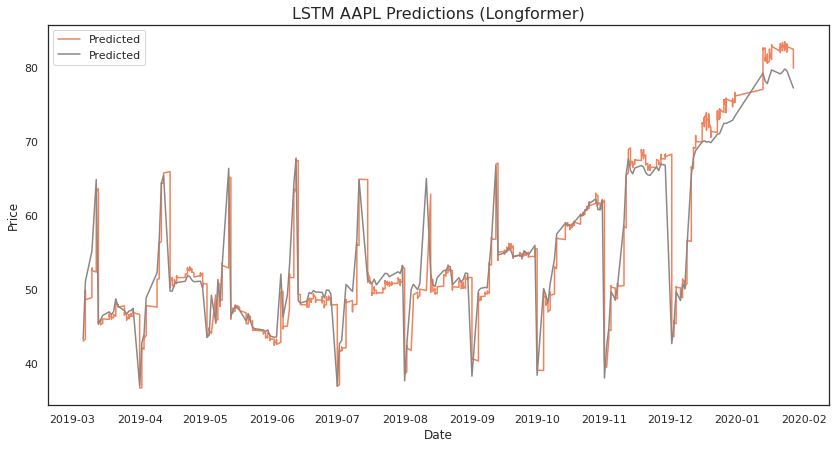

In [116]:
graph_df = pd.read_csv('/home/jonathiv/projects/annotator-disagreement/predictions/AAPL-predictions-longformer.csv')

graph_df['date'] = pd.to_datetime(graph_df['date'])

# plot predictions and actual closing prices
plt.figure(figsize=(14, 7))

plt.plot(graph_df['date'], graph_df['predictions'], label='Predicted', color='#f0835b')
plt.plot(graph_df['date'], graph_df['actuals'], label='Predicted', color='#8f8683')

plt.legend()
plt.title('LSTM AAPL Predictions (Longformer)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [94]:
# run LSTM with no text features
class LSTM_NoText(nn.Module):
    def __init__(self, num_features, hidden_dim, num_layers):
        super(LSTM_NoText, self).__init__()
        self.lstm = nn.LSTM(num_features, hidden_dim, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, numerical_features):
        lstm_out, _ = self.lstm(numerical_features)
        # Take the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out
    
num_features = len(numerical_cols)


# define objective function for optuna
def objective(trial):
    
    torch.cuda.empty_cache()
    
    # hyperparameters to tune
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_epochs = trial.suggest_int('num_epochs', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    
    model = LSTM_NoText(num_features, hidden_dim, num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for _, numerical_features, labels in train_loader:
            numerical_features, labels = numerical_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(numerical_features)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Loss: {avg_train_loss}')
        
        # validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for _, numerical_features, labels in dev_loader:
                numerical_features, labels =numerical_features.to(device), labels.to(device)
                outputs = model(numerical_features) 
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()
                
        avg_val_loss = val_loss / len(dev_loader)
        print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss}')
    
    return avg_val_loss

# create optuna study and optimize
study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=15)
study.optimize(objective, n_trials=15)

# print best hyperparameters
print('Best hyperparameters: ', study.best_params)

# train final model with the best hyperparameters
best_params = study.best_params
model = LSTM_NoText(num_features, best_params['hidden_dim'], best_params['num_layers']).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])


for epoch in range(best_params['num_epochs']):
    model.train()
    train_loss = 0.0
    for _, numerical_features, labels in train_loader:
        numerical_features, labels = numerical_features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(numerical_features)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}')

    # validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for _, numerical_features, labels in dev_loader:
            numerical_features, labels = numerical_features.to(device), labels.to(device)
            outputs = model(numerical_features)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()

    print(f'Epoch {epoch+1}, Validation Loss: {val_loss/len(dev_loader)}')
    
    
    
# generate predictions on the test set and evaluate
model.eval()
test_loss = 0.0
predictions = []
actuals = []


for _, numerical_features, labels in test_loader:
    # create predictions
    outputs = model(numerical_features.to(device))
    
    # calculate loss
    loss = criterion(outputs.squeeze(), labels.to(device))
    test_loss += loss.item()
    
    # save predictions to arrays for visualization
    predictions.extend(outputs.squeeze().tolist())
    actuals.extend(labels.tolist())

print(f'Test Loss: {test_loss/len(test_loader)}')


# convert data to np arrays for plotting
predictions = np.array(predictions)
actuals = np.array(actuals)

# rescale actuals and predictions
column_index = numerical_cols.index('Close')

column_mean = scaler.mean_[column_index]
column_scale = scaler.scale_[column_index]

actuals = (actuals * column_scale) + column_mean
predictions = (predictions * column_scale) + column_mean


# save to CSV so we can analyze it later
pd.DataFrame({'date':test_df['Date'][5:], 'predictions':predictions, 'actuals':actuals, 'title':test_df['title'][5:], 'content':test_df['content'][5:]}).to_csv(
    '/home/jonathiv/projects/annotator-disagreement/predictions/AAPL-predictions-no_text.csv', index=False)


# summary
# test loss: 
sns.set_theme(style='white')
# plot predictions and actual closing prices
plt.figure(figsize=(14, 7))
sns.lineplot(x=test_df['Date'][5:], y=predictions, label='Predicted', color='#f0835b')
sns.lineplot(x=test_df['Date'][5:], y=actuals, label='Actual', color='#8f8683')

plt.legend()
plt.title(f'{method} AAPL Predictions MSE:{test_loss/len(test_loader)}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()